## Building a CNN, Predicting, and Evaluating

## 1. Building a CNN

In [1]:
# Import Libraries
import os
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import keras
import random

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.mplot3d import Axes3D

from keras.applications import xception
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

from random import randint
from tqdm import tqdm

seed = 1000

Using TensorFlow backend.


In [2]:
def read_img(filepath, size):
    img = image.load_img(os.path.join(filepath), target_size=size)
    img = image.img_to_array(img)
    return img

In [3]:
# Set up paths
train_path = 'train'
test_path = 'test'

In [4]:
categories = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent',
              'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
num_categories = len(categories)
num_samples = 200

In [5]:
for category in categories:
    print('{}: {} images'.format(category, len(os.listdir(os.path.join(train_path, category)))))

Black-grass: 263 images
Charlock: 390 images
Cleavers: 287 images
Common Chickweed: 611 images
Common wheat: 221 images
Fat Hen: 475 images
Loose Silky-bent: 654 images
Maize: 221 images
Scentless Mayweed: 516 images
Shepherds Purse: 231 images
Small-flowered Cranesbill: 496 images
Sugar beet: 385 images


In [6]:
train = []
for category_id, category in enumerate(categories):
    for file in os.listdir(os.path.join(train_path, category)):
        train.append(['train/{}/{}'.format(category, file), category_id, category])
train = pd.DataFrame(train, columns=['file', 'category_id', 'category'])

In [7]:
test = []
for file in os.listdir(test_path):
    test.append(['test/{}'.format(file), file])
test = pd.DataFrame(test, columns=['filepath', 'file'])

In [8]:
train = pd.concat([train[train['category'] == c][:num_samples] for c in categories])
train = train.sample(frac=1)
train.index = np.arange(len(train))

### Validation Set

In [9]:
np.random.seed(seed=seed)
rnd = np.random.random(len(train))
train_idx = rnd < 0.8
valid_idx = rnd >= 0.8
ytr = train.loc[train_idx, 'category_id'].values
yv = train.loc[valid_idx, 'category_id'].values
print("Number of images in the Training Set: ", len(ytr))
print("Number of images in the Validation Set: ", len(yv))

Number of images in the Training Set:  1903
Number of images in the Validation Set:  497


In [71]:
validation_values = train.loc[valid_idx, ['file', 'category_id', 'category']].values

In [75]:
validation_df = pd.DataFrame(data=validation_values, columns=['file', 'category_id', 'category'])

In [78]:
validation_df.iloc[0]['file']

'train/Common Chickweed/096eb593d.png'

### Xception

In [10]:
input_size = 299
pooling = 'max'

In [11]:

x_train = np.zeros((len(train), input_size, input_size, 3), dtype='float32')
for i, file in tqdm(enumerate(train['file'])):
    img = read_img(file, (input_size, input_size))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x

2400it [01:03, 38.09it/s]


In [12]:
Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print((Xtr.shape, Xv.shape, ytr.shape, yv.shape))
xception_bottleneck = xception.Xception(weights='imagenet', include_top=False, pooling=pooling)
train_x_bf = xception_bottleneck.predict(Xtr, batch_size=32, verbose=1)
valid_x_bf = xception_bottleneck.predict(Xv, batch_size=32, verbose=1)

((1903, 299, 299, 3), (497, 299, 299, 3), (1903,), (497,))
497/497 [==============================] - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 54s - ETA: 39 - ETA: 23 - ETA: 8 - 242s 486ms/step


### LogReg Xception 

In [17]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=seed)
logreg.fit(train_x_bf, ytr)
valid_probs = logreg.predict_proba(valid_x_bf)
valid_preds = logreg.predict(valid_x_bf)

C:\Users\RichardHachar\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [18]:
print('Validation Xception Accuracy {}'.format(accuracy_score(yv, valid_preds)))

Validation Xception Accuracy 0.8048289738430584


In [19]:
cnf_matrix = confusion_matrix(yv, valid_preds)

In [20]:
abbreviations = ['BG', 'Ch', 'Cl', 'CC', 'CW', 'FH', 'LSB', 'M', 'SM', 'SP', 'SFC', 'SB']
class_df = pd.DataFrame({'class': categories, 'abbreviation': abbreviations})
class_df

,class,abbreviation
0,Black-grass,BG
1,Charlock,Ch
2,Cleavers,Cl
3,Common Chickweed,CC
4,Common wheat,CW
5,Fat Hen,FH
6,Loose Silky-bent,LSB
7,Maize,M
8,Scentless Mayweed,SM
9,Shepherds Purse,SP


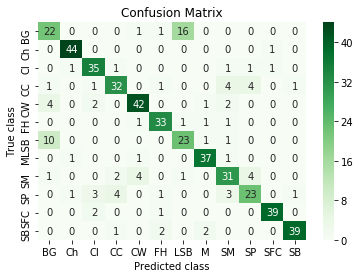

In [22]:
fig, ax = plt.subplots(1)
ax = sns.heatmap(cnf_matrix, ax=ax, cmap=plt.cm.Greens, annot=True)
ax.set_xticklabels(abbreviations)
ax.set_yticklabels(abbreviations)
plt.title('Confusion Matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
fig.savefig('Confusion matrix.png', dpi=300)
plt.show();

### Displaying and Classifying a Single Image

In [119]:
def display_and_classify_single_image():
    # Choose Random Image
    validation_set_length = valid_x_bf.shape[0] - 1
    image_number = random.randint(0, validation_set_length)

    # Predict
    predict_image = valid_x_bf[image_number].reshape(1,-1)
    single_prediction = logreg.predict(predict_image)

    # Get Predicted and Actual Values
    predicted_class_number = single_prediction[0]
    predicted_class = class_df.iloc[predicted_class_number][0]

    actual_class_number = yv[image_number]
    actual_class = class_df.iloc[actual_class_number][0]
    
    # Get Image
    file_loc = validation_df.iloc[image_number]
    
    def read_img(filepath, size):
        # Convert image to array
        img = image.load_img(filepath, target_size=size)
        img = image.img_to_array(img)
        return img

    def display_img(filepath, size, correct):
        # Display a specific image
        img = read_img(filepath['file'], size)
        plt.imshow(img/255.)
        plt.axis('off')
        plt.suptitle(filepath['category'], fontsize=14, fontweight='bold')
        if correct == True:
            plt.annotate('Predicted Class: {}'.format(predicted_class), (0,0), (0, -20), xycoords='axes fraction', textcoords='offset points', va='top', fontsize=14, fontweight='bold', color="green")
        else:
            plt.annotate('Predicted Class: {}'.format(predicted_class), (0,0), (0, -20), xycoords='axes fraction', textcoords='offset points', va='top', fontsize=14, fontweight='bold', color="red")
        
    if actual_class == predicted_class:
        correct = True
    else:
        correct = False
    
    display_img(file_loc, (224,224), correct)
    
    # Print
    print("Image number {} chosen.".format(image_number))
    print("Predicted Class: {}".format(predicted_class))
    print("Actual Class: {}".format(actual_class))
    
    if actual_class == predicted_class:
        print("The algorithm was correct!")
    else:
        print("The algorithm was incorrect.")
    
    return correct

# Set up a running counter to track prediction accuracy:
count = 0
correct_count = 0

Image number 377 chosen.
Predicted Class: Maize
Actual Class: Maize
The algorithm was correct!
So far, after 25 predictions, the algorithm is 76.0% accurate.


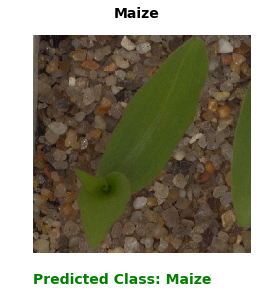

In [144]:
correct = display_and_classify_single_image()
count += 1
if correct == True:
    correct_count += 1
    
print("So far, after {} predictions, the algorithm is {}% accurate.".format(count, correct_count/count*100))